In [2]:
! rm -rf *

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"klausx3","key":"f152c4e63afb830348afbe87d30e7655"}'}

In [4]:
! pip install -q kaggle
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [00:38<00:00, 42.7MB/s]
100% 1.49G/1.49G [00:38<00:00, 41.2MB/s]


In [6]:
!mkdir images
!mv defocused_blurred images
!mv motion_blurred images
!mv sharp images

In [7]:
%%capture

! pip install transformers pytorch-lightning --quiet

In [8]:
import math
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Init Dataset and Split into Training and Validation Sets


In [9]:
data_dir = Path('images')

In [10]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

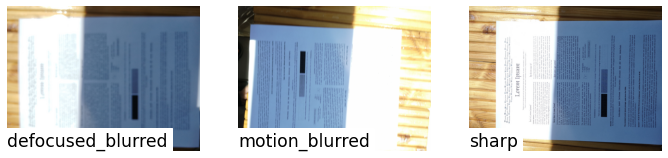

In [11]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [12]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [13]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

## Init Feature Extractor, Model, Data Loaders


In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model ch

# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [15]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [16]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=32, max_epochs=12)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | MulticlassAccuracy        | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.602   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [17]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])



Preds:  tensor([2, 0, 1, 2, 2, 1, 0, 1])
Labels: tensor([2, 0, 1, 2, 2, 1, 0, 1])


In [18]:
# save the model
model_dir = "./"
model_name = "vit_model"
model.save_pretrained(model_dir + model_name)


In [21]:
from PIL import Image

# Load the saved model
model_dir = "./"
model_name = "quality_model"
loaded_model = ViTForImageClassification.from_pretrained(model_dir + model_name)

# Load and preprocess the image
image_path = "/content/iStock-grocery-store1.jpg"
image = Image.open(image_path)
inputs = feature_extractor(image, return_tensors="pt")

# Make the prediction
outputs = loaded_model(**inputs)
predicted_class = id2label[str(outputs.logits.argmax(1).item())]

print(f"Predicted class: {predicted_class}")


Predicted class: defocused_blurred
